
# This is the draft notebook 

In [ ]:
# import modules

import numpy as np
import pandas as pd # import library for data analysis

from get_regression_coefs_general import get_regression_coefs # import our function to get GDP trend

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns # for nicer plots (not essential)
sns.set_theme('talk', style = 'white')

import openpyxl
print(openpyxl.__version__)

In [2]:
# 2.1) Load dataset
data = pd.read_excel('pwt100.xlsx', sheet_name = 'Data', header = 0)

In [ ]:
# 2.2) Clean data

# Subset relevant columns and compute per capita real GDP
data = data.loc[:, ("country", "year", "rgdpna", "pop")]
data["rgdpna_pc"] = data["rgdpna"] / data["pop"]

# select Indonesia
data_indonesia = data.loc[data["country"] == "Indonesia", ("year", "rgdpna", "rgdpna_pc")]
# Reset the index
data_indonesia = data_indonesia.reset_index(drop = True)

# Subset the RGDP and RGDP per capita series
ymax = 2019
ymin = 1960
# We use logical indexing to subset the data to rows of years ymin <= year <= ymax
Y_gdp = data_indonesia.loc[np.logical_and(data_indonesia["year"] <= ymax, data_indonesia["year"] >= ymin), "rgdpna"]
Y_pc = data_indonesia.loc[np.logical_and(data_indonesia["year"] <= ymax, data_indonesia["year"] >= ymin), "rgdpna_pc"]
y_gdp = np.log(Y_gdp)
y_pc = np.log(Y_pc)
data_indonesia = data_indonesia[data_indonesia["year"] >= ymin] 

# Compute separate sample sizes for the subsample used for estimation and the whole sample.
T_gdp = len(Y_gdp) # sample size used for regression
T_pc = len(Y_pc)
T_all = data_indonesia["year"].max() - (ymin - 1)

# Check values
print(T_gdp)
print(T_pc)
print(T_all)

In [ ]:
# 3.1) Additive Linear Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T
# The dependent variable is RGDP and RGDP per capita in *levels*

def additive_linear_model(Y, T_input):
    T = len(Y)
    x1 = np.empty(T) # initialise an empty vector for the first regressor
    x2 = np.empty(T) # initialise an empty vector for the second regressor

    for t in range(T):
        x1[t] = 1.
        x2[t] = t + 1 # recall that Python starts indexing at 0
        
    a_add_lin, b_add_lin = get_regression_coefs(Y, x1, x2)
    
    # Initialise predicted values yhat
    Yhat_add_lin = np.empty(T_input)
    
    # Create loop to compute trend for all years
    for t in range(T_input):
        Yhat_add_lin[t] = a_add_lin + b_add_lin * (t + 1) # recall that Python indexing starts at 0
        
    # Let us convert into log-units
    yhat_add_lin = np.log(Yhat_add_lin)

    return Yhat_add_lin, yhat_add_lin

# Apply the function to both RGDP and RGDP per capita
Yhat_add_lin_gdp, yhat_add_lin_gdp = additive_linear_model(Y_gdp, T_all)
Yhat_add_lin_pc, yhat_add_lin_pc = additive_linear_model(Y_pc, T_all)

In [5]:
# 3.2) Additive Quadratic Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T, third regressor x3 is the vector 1, 4, ..., T^2
# The dependent variable is per capita GDP in *levels*

def additive_quadratic_model(Y, T_input):
    T = len(Y)
    x1 = np.empty(T) 
    x2 = np.empty(T) 
    x3 = np.empty(T)

    for t in range(T):
        x1[t] = 1
        x2[t] = t + 1
        x3[t] = (t + 1) ** 2

    a_add_quad, b1_add_quad, b2_add_quad = get_regression_coefs(Y, x1, x2, x3)
    
    # Initialise predicted values yhat
    Yhat_add_quad = np.empty(T_input)
    
    # Create loop to compute trend for all years
    for t in range(T_input):
        Yhat_add_quad[t] = a_add_quad + b1_add_quad * (t + 1) + b2_add_quad * (t + 1) ** 2
        
    # Take the natural logarithm of the shifted fitted values
    yhat_add_quad = np.log(Yhat_add_quad)
    
    return Yhat_add_quad, yhat_add_quad

# Apply the function to both RGDP and RGDP per capita
Yhat_add_quad_gdp, yhat_add_quad_gdp = additive_quadratic_model(Y_gdp, T_all)
Yhat_add_quad_pc, yhat_add_quad_pc = additive_quadratic_model(Y_pc, T_all)

In [6]:
# 3.3) Exponential Linear Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T
# The dependent variable is per capita GDP in *ln*

def exponential_linear_model(Y, T_input):
    T = len(Y)
    x1 = np.empty(T) 
    x2 = np.empty(T) 

    for t in range(T):
        x1[t] = 1
        x2[t] = t + 1
        
    y_exp_lin = np.log(Y)
    
    a_exp_lin, b_exp_lin = get_regression_coefs(y_exp_lin, x1, x2)
    
    # Initialise predicted values yhat
    yhat_exp_lin = np.empty(T_input)
    
    # Create loop to compute trend for all years
    for t in range(T_input):
        yhat_exp_lin[t] = a_exp_lin + b_exp_lin * (t + 1)

    return yhat_exp_lin

# Apply the function to both RGDP and RGDP per capita
yhat_exp_lin_gdp = exponential_linear_model(Y_gdp, T_all)
yhat_exp_lin_pc = exponential_linear_model(Y_pc, T_all)

In [7]:
# 3.4) Exponential Quadratic Model
# First regressor x1 is T x 1 vector of ones, second regressor x2 is the vector 1, 2, ..., T, third regressor x3 is the vector 1, 4, ..., T^2
# The dependent variable is per capita GDP in *ln*

def exponential_quadratic_model(Y, T_input):
    T = len(Y)
    x1 = np.empty(T) 
    x2 = np.empty(T) 
    x3 = np.empty(T)

    for t in range(T):
        x1[t] = 1
        x2[t] = t + 1
        x3[t] = (t + 1) ** 2
        
    y_exp_quad = np.log(Y)
    
    a_exp_quad, b1_exp_quad, b2_exp_quad = get_regression_coefs(y_exp_quad, x1, x2, x3)
    
    # Initialise predicted values yhat
    yhat_exp_quad = np.empty(T_input)
    
    # Create loop to compute trend for all years
    for t in range(T_input):
        yhat_exp_quad[t] = a_exp_quad + b1_exp_quad * (t + 1) + b2_exp_quad * (t + 1) ** 2
        
    return yhat_exp_quad 

# Apply the function to both RGDP and RGDP per capita
yhat_exp_quad_gdp = exponential_quadratic_model(Y_gdp, T_all)
yhat_exp_quad_pc = exponential_quadratic_model(Y_pc, T_all)   

In [ ]:
lw = 4

#Plot Additive Graph for RGDP 
plt.figure()
plt.plot(data_indonesia['year'],np.log(data_indonesia['rgdpna']), label="Actual Real GDP")
plt.plot(data_indonesia['year'],yhat_add_lin_gdp, label="Linear Additive Real GDP", linestyle = "dashdot")
plt.plot(data_indonesia['year'],yhat_add_quad_gdp, label="Quadratic Additive Real GDP", linestyle = "dashdot")

#labels
plt.xlabel("year")
plt.ylabel("ln(Real GDP)")
plt.legend(fontsize='xx-small', loc='upper left')

#title
plt.title("Additive Model: Real GDP Time Trend", fontsize = 15)

#Plot Exponential Graph for RGDP PC
plt.figure()
plt.plot(data_indonesia['year'],np.log(data_indonesia['rgdpna']), label="Actual Real GDP")
plt.plot(data_indonesia['year'],yhat_exp_lin_gdp, label="Linear Exponential Real GDP", linestyle = "dashdot")
plt.plot(data_indonesia['year'],yhat_exp_quad_gdp, label="Quadratic Exponential GDP", linestyle = "dashdot")

#labels
plt.xlabel("year")
plt.ylabel("ln(Real GDP)")
plt.legend(fontsize='xx-small', loc='upper left')

#title
plt.title("Exponential Model: Real GDP Time Trend", fontsize = 15)


#Plot Additive Graph for RGDP PC
plt.figure()
plt.plot(data_indonesia['year'],np.log(data_indonesia['rgdpna_pc']), label="Actual Real GDP per capita")
plt.plot(data_indonesia['year'],yhat_add_lin_pc, label="Linear Additive Real GDP per capita", linestyle = "dashdot")
plt.plot(data_indonesia['year'],yhat_add_quad_pc, label="Quadratic Additive Real GDP per capita", linestyle = "dashdot")

#labels
plt.xlabel("year")
plt.ylabel("ln(Real GDP PC)")
plt.legend(fontsize='xx-small', loc='upper left')

#title
plt.title("Additive Model: Real GDP per capita Time Trend", fontsize = 15)

#Plot Exponential Graph for RGDP PC
plt.figure()
plt.plot(data_indonesia['year'],np.log(data_indonesia['rgdpna_pc']), label="Actual Real GDP per capita")
plt.plot(data_indonesia['year'],yhat_exp_lin_pc, label="Linear Exponential Real GDP per capita", linestyle = "dashdot")
plt.plot(data_indonesia['year'],yhat_exp_quad_pc, label="Quadratic Exponential GDP per capita", linestyle = "dashdot")

#labels
plt.xlabel("year")
plt.ylabel("ln(Real GDP PC)")
plt.legend(fontsize='xx-small', loc='upper left')

#title
plt.title("Exponential Model: Real GDP per capita Time Trend", fontsize = 15)

In [ ]:
# Split data set into 2 subperiods - before and after 1998 
data_indonesia_before_1998 = data_indonesia[data_indonesia["year"] <= 1998]
data_indonesia_after_1998 = data_indonesia[data_indonesia["year"] > 1998]

# Subset the RGDP and RGDP per capita series
Y_gdp_before_1998 = data_indonesia_before_1998["rgdpna"]
Y_gdp_after_1998 = data_indonesia_after_1998["rgdpna"]
Y_pc_before_1998 = data_indonesia_before_1998["rgdpna_pc"]
Y_pc_after_1998 = data_indonesia_after_1998["rgdpna_pc"]

# Compute separate sample sizes for the subsample used for estimation and the whole sample.
T_gdp_before_1998 = len(Y_gdp_before_1998) 
T_gdp_after_1998 = len(Y_gdp_after_1998) 
T_pc_before_1998 = len(Y_pc_before_1998) 
T_pc_after_1998 = len(Y_pc_after_1998) 
T_before_1998 = 1998 - ymin + 1
T_after_1998 = ymax - 1998

# Check values
print(T_gdp_before_1998)
print(T_gdp_after_1998)
print(T_pc_before_1998)
print(T_pc_after_1998)
print(T_before_1998)
print(T_after_1998)

# Derive fitted values for the 2 subperiods using exponential quadratic model 
yhat_exp_quad_gdp_before_1998 = exponential_quadratic_model(Y_gdp_before_1998, T_before_1998)
yhat_exp_quad_gdp_after_1998 = exponential_quadratic_model(Y_gdp_after_1998, T_after_1998)
yhat_exp_quad_pc_before_1998 = exponential_quadratic_model(Y_pc_before_1998, T_before_1998)
yhat_exp_quad_pc_after_1998 = exponential_quadratic_model(Y_pc_after_1998, T_after_1998)

#Plot Exponential Quadratic Graph for RGDP
plt.figure()
plt.plot(data_indonesia['year'],np.log(data_indonesia['rgdpna']), label="Actual Real GDP")
plt.plot(data_indonesia_before_1998['year'],yhat_exp_quad_gdp_before_1998, label="Quadratic Exponential Real GDP (Before 1998)", linestyle = "dashdot")
plt.plot(data_indonesia_after_1998['year'],yhat_exp_quad_gdp_after_1998, label="Quadratic Exponential GDP (After 1998)", linestyle = "dashdot")

#labels
plt.xlabel("year")
plt.ylabel("ln(Real GDP)")
plt.legend(fontsize='xx-small', loc='upper left')

#title
plt.title("Revised Exponential Quadratic Model: Real GDP Time Trend", fontsize = 15)


#Plot Exponential Quadratic Graph for RGDP PC
plt.figure()
plt.plot(data_indonesia['year'],np.log(data_indonesia['rgdpna_pc']), label="Actual Real GDP")
plt.plot(data_indonesia_before_1998['year'],yhat_exp_quad_pc_before_1998, label="Quadratic Exponential Real GDP per capita (Before 1998)", linestyle = "dashdot")
plt.plot(data_indonesia_after_1998['year'],yhat_exp_quad_pc_after_1998, label="Quadratic Exponential GDP per capita(After 1998)", linestyle = "dashdot")

#labels
plt.xlabel("year")
plt.ylabel("ln(Real GDP per capita)")
plt.legend(fontsize='xx-small', loc='upper left')

#title
plt.title("Revised Exponential Quadratic Model: Real GDP per capita Time Trend", fontsize = 15)


In [ ]:
# Part B, calculating TFP 
# Load dataset
data = pd.read_excel('pwt100.xlsx', sheet_name='Data', header=0)

# Extract relevant variables in production function and select Indonesia
data_indonesia_b = data.loc[data["country"] == "Indonesia", ["year", "rgdpna", "emp", "rnna", "hc"]]

# Drop rows with missing values in specified columns
data_indonesia_b.dropna(subset=["rgdpna", "emp", "rnna", "hc"], inplace=True)

# Define a list of alpha values for robustness check
alpha_values = [0.25, 0.3, 0.35]

# Calculate TFP for each alpha and store the results in a dictionary
tfp_results = {}

for alpha in alpha_values:
    tfp = (1/(data_indonesia_b["emp"]*data_indonesia_b["hc"]))*(data_indonesia_b["rgdpna"]/(data_indonesia_b["rnna"])**alpha)**(1/(1-alpha))
    tfp_results[f"TFP_alpha_{alpha}"] = tfp

# Convert the results dictionary to a DataFrame for better visualization
tfp_df = pd.DataFrame(tfp_results)

# Add the year column for reference
tfp_df["year"] = data_indonesia_b["year"]

# Merge the TFP DataFrame with the original Indonesia DataFrame
data_indonesia_b = data_indonesia_b.merge(tfp_df, on="year")

# Display the updated DataFrame
display(data_indonesia_b)

#Plot Time Series
plt.figure()
plt.plot(data_indonesia_b['year'],data_indonesia_b["TFP_alpha_0.25"], label="alpha 0.25")
plt.plot(data_indonesia_b['year'],data_indonesia_b["TFP_alpha_0.3"], label="alpha 0.3")
plt.plot(data_indonesia_b['year'],data_indonesia_b["TFP_alpha_0.35"], label="alpha 0.35")

#labels
plt.xlabel("year")
plt.ylabel("TFP")
plt.legend(fontsize='xx-small', loc='upper left')

#title
plt.title("Time Series of TFP")

,year,rgdpna,emp,rnna,hc,TFP_alpha_0.25,TFP_alpha_0.3,TFP_alpha_0.35,rgdpna_million,rnna_million,k_tilda,labour_productivity
0,1960,147538.921875,28.498953,762376.7500,1.158581,2584.620672,2210.380296,1845.382708,0.147539,0.762377,10.445932,5176.994487
1,1961,159648.609375,29.060551,765323.1875,1.176857,2768.498671,2384.611743,2007.325066,0.159649,0.765323,9.384251,5493.653960
2,1962,159406.125000,29.569380,764462.1875,1.195421,2674.185813,2303.290030,1938.785826,0.159406,0.764462,9.389539,5390.918783
3,1963,153244.640625,30.088734,756324.5000,1.214278,2463.517674,2116.045162,1775.561034,0.153245,0.756324,9.782757,5093.090400
4,1964,160370.234375,30.618654,751605.5625,1.233432,2537.466753,2190.323887,1848.360916,0.160370,0.751606,9.086159,5237.664368


,Y growth,K contribution,h contribution,L contribution,A contribution
year,,,,,
1960-1970,0.281279,0.010385,0.389497,0.440837,0.159280
1970-1980,0.767951,0.245765,0.103752,0.265194,0.385288
1980-1990,0.608867,0.383940,0.255054,0.554069,-0.193064
1990-2000,0.413341,0.521737,0.241396,0.367473,-0.130606
2000-2010,0.510038,0.280599,0.137946,0.228779,0.352676


,Y growth,K growth,h growth,L growth,A growth
year,,,,,
1960-1970,0.281279,0.009737,0.156511,0.177141,0.064003
1970-1980,0.767951,0.629118,0.113824,0.290938,0.422690
1980-1990,0.608867,0.779229,0.221849,0.481935,-0.167929
1990-2000,0.413341,0.718852,0.142541,0.216988,-0.077121
2000-2010,0.510038,0.477054,0.100511,0.166694,0.256969


,Y growth,"Sum of A, h, L growth",Difference
year,,,
1960-1970,0.281279,0.397654,0.116375
1970-1980,0.767951,0.827451,0.059500
1980-1990,0.608867,0.535855,-0.073012
1990-2000,0.413341,0.282408,-0.130933
2000-2010,0.510038,0.524174,0.014136


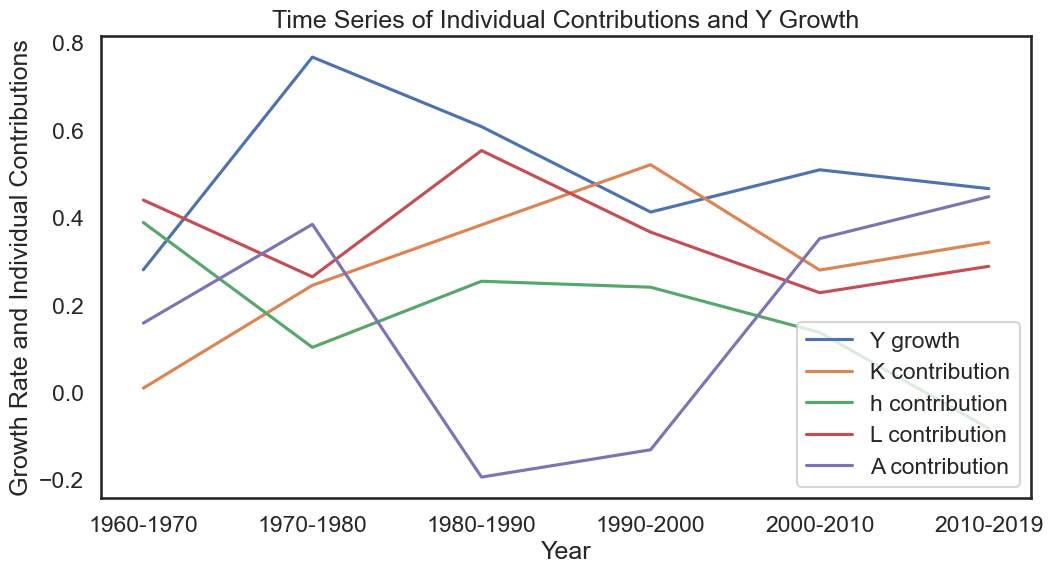

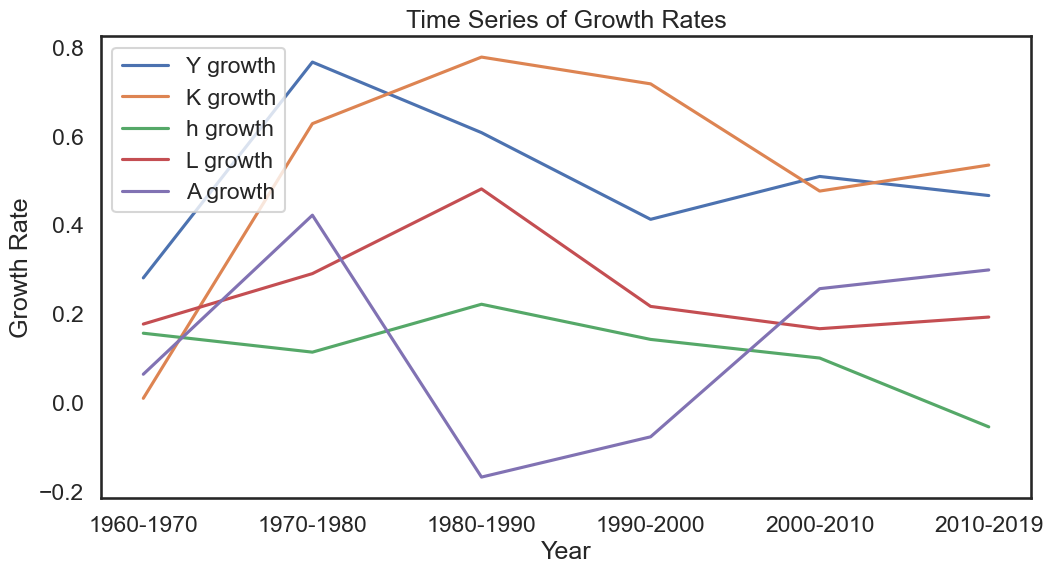

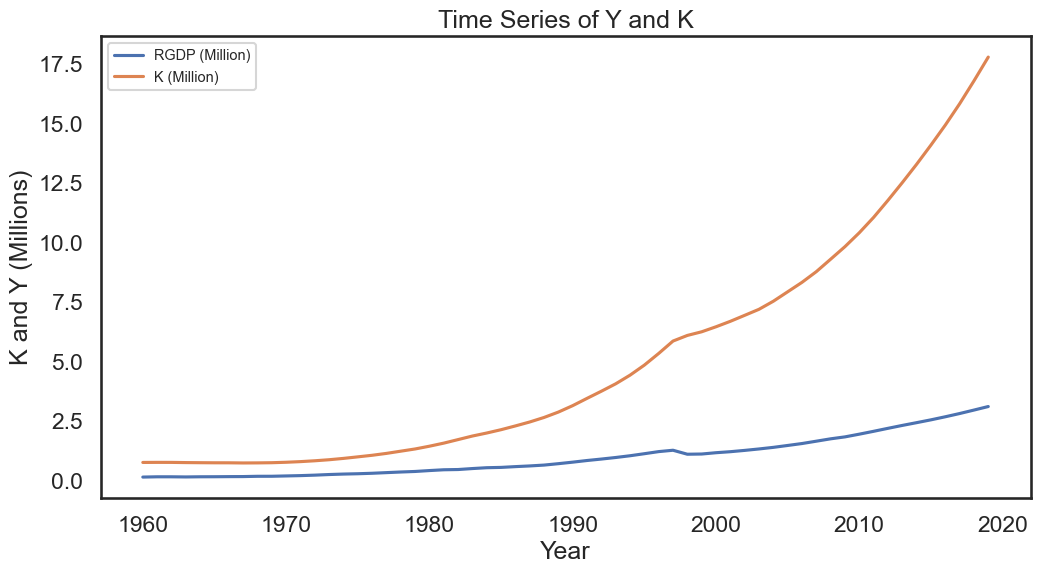

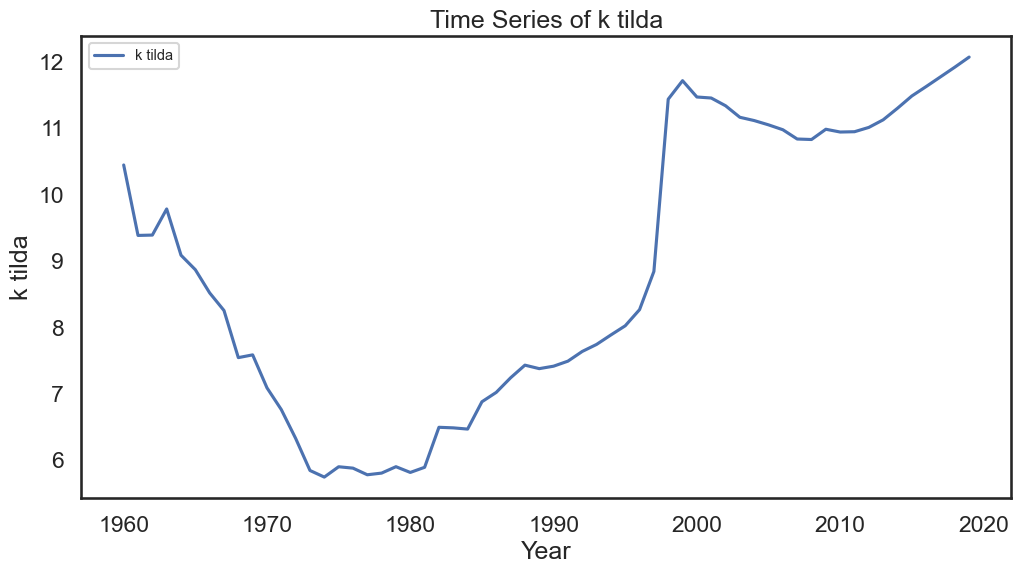

In [19]:
# Part C, Growth Accounting
# Ensure the year column is of integer type
data_indonesia_b["year"] = data_indonesia_b["year"].astype(int)

# Display the updated DataFrame
display(data_indonesia_b.head())

# Initialise dataframe with NaNs
avg_growth_rates = pd.DataFrame(
    data = np.full((6, 5), np.nan),
    columns = ['Y growth', 'K growth', 'L growth','h growth', 'A growth']
)
avg_growth_rates['year'] = ["1960-1970", "1970-1980", "1980-1990", "1990-2000", "2000-2010", "2010-2019"]
avg_growth_rates = avg_growth_rates.set_index('year')

# Set alpha = 0.3 
alpha = 0.3 

# Fill with average growth rates from data_indonesia_b
cols = ['rgdpna', 'rnna', 'emp', 'hc', 'TFP_alpha_0.3']

# Ensure the years exist in the DataFrame
years = [1960, 1970, 1980, 1990, 2000, 2010, 2019]
for start, end in zip(years[:-1], years[1:]):
    if start in data_indonesia_b["year"].values and end in data_indonesia_b["year"].values:
        avg_growth_rates.loc[f"{start}-{end}"] = np.log(data_indonesia_b.loc[data_indonesia_b["year"] == end, cols].values / data_indonesia_b.loc[data_indonesia_b["year"] == start, cols].values).flatten()

# Compute contribution rates
df_contribs_long = avg_growth_rates.copy()
df_contribs_long['K contribution'] = alpha * (df_contribs_long['K growth'] / df_contribs_long['Y growth']) 
df_contribs_long['h contribution'] = (1 - alpha) * (df_contribs_long['h growth'] / df_contribs_long['Y growth'])
df_contribs_long['L contribution'] = (1 - alpha) * (df_contribs_long['L growth'] / df_contribs_long['Y growth'])
df_contribs_long['A contribution'] = (1 - alpha) * (df_contribs_long['A growth'] / df_contribs_long['Y growth'])

# Create dataframe of the contributions
df_contribs = df_contribs_long[['Y growth', 'K contribution', 'h contribution', 'L contribution', 'A contribution']]

# Display dataframe of the contributions
display(df_contribs.head()) 

# Create dataframe of the growth rates
df_contribs_growth_rates = df_contribs_long[['Y growth', 'K growth', 'h growth', 'L growth', 'A growth']]

# Display dataframe of the growth rates
display(df_contribs_growth_rates.head())

# Create dataframe of the growth rates
df_contribs_growth_rates_sum = df_contribs_growth_rates.copy()

# Calculate the sum of A growth, h growth, and L growth
df_contribs_growth_rates_sum.loc[:,'Sum of A, h, L growth'] = df_contribs_growth_rates_sum['A growth'] + df_contribs_growth_rates_sum['h growth'] + df_contribs_growth_rates_sum['L growth']

# Calculate the difference between gA+gL+gh and gY 
df_contribs_growth_rates_sum.loc[:,'Difference'] = df_contribs_growth_rates_sum['Sum of A, h, L growth'] - df_contribs_growth_rates_sum['Y growth']

# Create a new dataframe with sub-periods as rows, and columns for gY and the sum of A, h, L growth
df_table = df_contribs_growth_rates_sum[['Y growth', 'Sum of A, h, L growth', 'Difference']]

# Display the resulting dataframe
display(df_table.head())


# Plotting the time series of contributions
plt.figure(figsize=(12, 6))

# Plot Y growth
plt.plot(df_contribs_long.index, df_contribs_long['Y growth'], label='Y growth')

# Plot K contribution
plt.plot(df_contribs_long.index, df_contribs_long['K contribution'], label='K contribution')

# Plot h contribution
plt.plot(df_contribs_long.index, df_contribs_long['h contribution'], label='h contribution')

# Plot L contribution
plt.plot(df_contribs_long.index, df_contribs_long['L contribution'], label='L contribution')

# Plot A contribution
plt.plot(df_contribs_long.index, df_contribs_long['A contribution'], label='A contribution')

# Adding titles and labels
plt.title('Time Series of Individual Contributions and Y Growth')
plt.xlabel('Year')
plt.ylabel('Growth Rate and Individual Contributions')
plt.legend()

# Display the plot
plt.show()


# Plotting the time series of growth rates
plt.figure(figsize=(12, 6))

# Plot Y growth
plt.plot(df_contribs_long.index, df_contribs_long['Y growth'], label='Y growth')

# Plot K contribution
plt.plot(df_contribs_long.index, df_contribs_long['K growth'], label='K growth')

# Plot h contribution
plt.plot(df_contribs_long.index, df_contribs_long['h growth'], label='h growth')

# Plot L contribution
plt.plot(df_contribs_long.index, df_contribs_long['L growth'], label='L growth')

# Plot A contribution
plt.plot(df_contribs_long.index, df_contribs_long['A growth'], label='A growth')

# Adding titles and labels
plt.title('Time Series of Growth Rates')
plt.xlabel('Year')
plt.ylabel('Growth Rate')
plt.legend()

# Display the plot
plt.show()


# Scale Y and K to millions
data_indonesia_b["rgdpna_million"] = data_indonesia_b["rgdpna"] / 1e6
data_indonesia_b["rnna_million"] = data_indonesia_b["rnna"] / 1e6

# Plotting the time series of Y and K in millions
plt.figure(figsize=(12, 6))
plt.plot(data_indonesia_b['year'], data_indonesia_b["rgdpna_million"], label="RGDP (Million)")
plt.plot(data_indonesia_b['year'], data_indonesia_b["rnna_million"], label="K (Million)")

# Labels
plt.xlabel("Year")
plt.ylabel("K and Y (Millions)")
plt.legend(fontsize='xx-small', loc='upper left')

# Title
plt.title("Time Series of Y and K")

# Show plot
plt.show()


# Create k tilda variable and add it to the DataFrame
data_indonesia_b["k_tilda"] = data_indonesia_b["rnna"] / (data_indonesia_b["TFP_alpha_0.3"]*data_indonesia_b["hc"]*data_indonesia_b["emp"]) 

# Plotting the time series of k tilda 
plt.figure(figsize=(12, 6))
plt.plot(data_indonesia_b['year'], data_indonesia_b["k_tilda"], label="k tilda")

# Labels
plt.xlabel("Year")
plt.ylabel("k tilda")
plt.legend(fontsize='xx-small', loc='upper left')

# Title
plt.title("Time Series of k tilda")

# Show plot
plt.show()

In [ ]:
# Part D, Labour Productivity 
# Calculate labor productivity (GDP per worker)
data_indonesia_b["labour_productivity"] = data_indonesia_b["rgdpna"] / data_indonesia_b["emp"]

# Display the updated DataFrame
print(data_indonesia_b[["year", "labour_productivity"]])

#Plot Time Series
plt.figure()
plt.plot(data_indonesia_b['year'],data_indonesia_b["TFP_alpha_0.3"], label="TFP")
plt.plot(data_indonesia_b['year'],data_indonesia_b["labour_productivity"], label="Labour Productivity")

#labels
plt.xlabel("year")
plt.ylabel("Productivity")
plt.legend(fontsize='xx-small', loc='upper left')

#title
plt.title("Time Series of TFP and Labour Productivity")
